In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*1.5      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [209]:
# Plot input scaling function (for CEDAR 2016 poster)


R_E = 6378*1e3
H_IONO = 1e5
H_E = 5000.0
Z0 = 377.0
A = 5e3
B = 1e5
D2R = np.pi/180.0

dfreq = 100
dlat = 0.02

freqs = np.linspace(200,60000,10000)
lats  = np.linspace(0,10,8)

I0 = -100e3
center_lat = 0

dist_lat =  (R_E + H_IONO/2.0)*abs(center_lat - lats)*D2R    


def scale_factor(I0, center_lat, dlat, dfreq, frequency, ray_lat, dlong = 0.7):

    
    # Latitude distance, longitude distance between source and ray
    dist_lat = (R_E + H_IONO/2.0)*abs(center_lat - ray_lat)*D2R    
    dist_long= (R_E + H_IONO/2.0)*abs(dlong)*D2R
    #print "dist_lat: ",dist_lat,"dist_long: ",dist_long

    dist_iono = np.hypot(dist_lat, dist_long)
    dist_tot =  np.hypot(dist_iono, H_IONO)
    #print "Dist_iono: ", dist_iono,"dist_tot: ",dist_tot
    xi = np.arctan2(dist_iono, H_IONO)
    #print "xi: ",xi
    # Power at sub-ionosphere point
    w = 2*np.pi*frequency
    w_sq = pow(w, 2)

    S = ( 1.0/(Z0) * pow( H_E * I0 * (2e-7)*(np.sin(xi)/dist_tot)* w * (A - B),2)
        /( (w_sq + pow(A, 2))*(w_sq + pow(B,2)))  )

    # Get ionosphere attenuation:
    #atten_factor = pow(10, -ionoAbsorp(ray_lat, frequency)/10.0)

    S_vert = S * np.cos(xi) #*atten_factor   # Vertical component

    # print ("I0: %2.3f, center_lat: %2.3f, dlat: %2.3f, dfreq: %2.3f, f: %ld, lat: %2.3f, dlong: %g, S_vert: %e"
    #         %(I0, center_lat, dlat, dfreq, frequency, ray_lat, dlong, S_vert))

    # print "S_vert:", S_vert
    # I don't know where Jacob got this attenuation factor from. Geometric spreading? Hmm.
    return S_vert * dlat * D2R * (R_E + H_IONO) * dfreq * 0.87788331
#     return S_vert / (dlat*D2R*(R_E + H_IONO))

scale = np.zeros([len(freqs), len(lats)])

for f_ind, f in enumerate(freqs):
    for lat_ind, lat in enumerate(lats):
        scale[f_ind, lat_ind] = scale_factor(I0, center_lat, dlat, dfreq, f, lat, dlong=0)

<IPython.core.display.Javascript object>


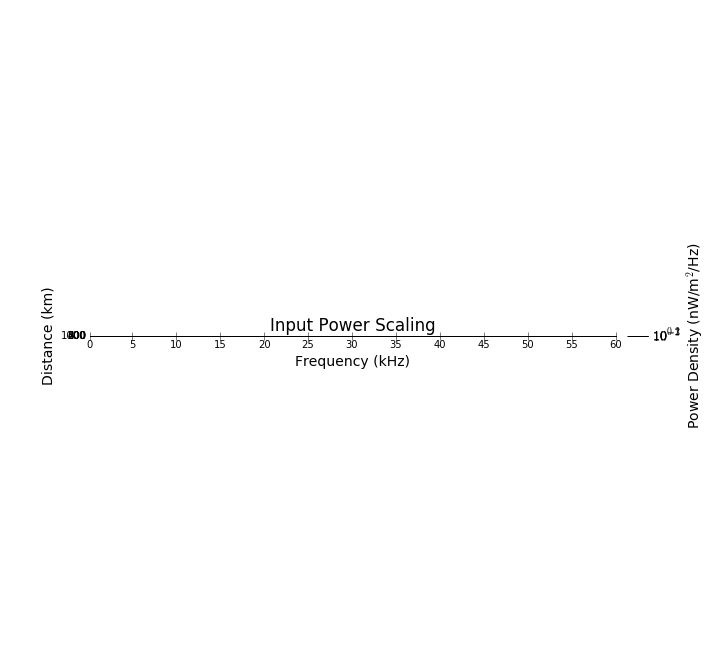

In [210]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nearest_index(grid, values):
    # Find closest index of a value in an array (i.e., quick quantize to grid value)
    idx = np.searchsorted(grid, values, side="left")
    idx = np.clip(idx, 0, len(grid) - 1)
    idx_l = np.clip(idx - 1, 0, len(grid) - 1)

    idx[abs(values - grid[idx_l]) < abs(values - grid[idx])] -= 1
    return idx



scale_scaled = np.log10((1e9)*scale.T/(dlat*D2R*(R_E + H_IONO)*dfreq))

clims = [-3, 0]
fig = plt.figure()
ax1 = fig.add_subplot(111)
p1 = ax1.imshow(scale_scaled, origin='lower',interpolation='none')
p1.set_clim(clims)
# ax1.set_aspect(len(freqs)/(1.0*len(lats)))


# p1 = ax1.pcolor(freqs, dist_lat/1000, np.log10(scale.T))
# ax1.set_xlim([200,50000])
# ax1.set_ylim([200,5000])
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right",size="4%",pad=0.15)
cb = plt.colorbar(p1, cax=cax)
cb.set_label('Power Density (nW/m$^2$/Hz)')
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.ax.tick_params(labelsize=14)
# Axis labels
xticklabels = np.arange(0,65,step=5)
xticks = nearest_index(freqs/1000, xticklabels)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels)
yticklabels = np.arange(0, 1200, step=200)
yticks = nearest_index(dist_lat/1000, yticklabels)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels)
ax1.set_xlabel('Frequency (kHz)')
ax1.set_ylabel('Distance (km)')
ax1.set_title('Input Power Scaling')
# ax1.layout('tight')

# plt.savefig('power_scaling.png',dpi=300)



In [212]:
# Show frequency dependence curve only:
derp = (scale_scaled.T)
derp = derp # - np.max(derp, axis=0)
print np.shape(derp)
g_cont  = derp[:,1]  # 'gain' on the continuous vector

# print np.shape(f_dep)
# select our quantized frequencies:
f1 = 200; f2 = 60000;
num_freqs = 33
flogs = np.linspace(np.log10(f1), np.log10(f2), num_freqs)
# f_selected = np.round(pow(10, flogs)*100)/100.
f_selected = np.round(pow(10, flogs))


print f_selected
# Select magnitude at our quantized frequencies:
closest_inds = nearest_index(freqs, f_selected)
g_selected = g_cont[closest_inds]

f_cont = freqs

# Interpolate back onto continuous axis
x = interpolate.interp1d(f_selected, g_selected)


g_int = x(f_cont)



variation = np.zeros(len(closest_inds)-1)
f_var     = np.zeros(len(closest_inds)-1)
for i, inds in enumerate(zip(closest_inds[0:-2], closest_inds[1:-1])):
    v = np.sqrt(np.sum(pow(g_cont[inds[0]:inds[1]] - g_int[inds[0]:inds[1]], 2)))
    variation[i] = 100.*v/(inds[1] - inds[0])
    f_var[i] = (freqs[inds[1]] + freqs[inds[0]])/2.
    
fig, ax = plt.subplots(2,1)
ax[0].plot(freqs/1000, g_cont);
ax[0].plot(f_selected/1000, g_selected, 'ro-')
ax[0].grid()


ax[1].loglog(f_var/1000, variation, 'bo')
ax[1].set_ylabel('RMS \% error in band')
ax[1].set_xlabel('Frequency (kHz)')
ax[1].grid()

(10000, 8)
[   200.    239.    286.    341.    408.    488.    583.    696.    832.
    995.   1189.   1421.   1698.   2029.   2425.   2899.   3464.   4140.
   4948.   5913.   7067.   8446.  10094.  12063.  14417.  17230.  20592.
  24609.  29411.  35150.  42008.  50204.  60000.]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


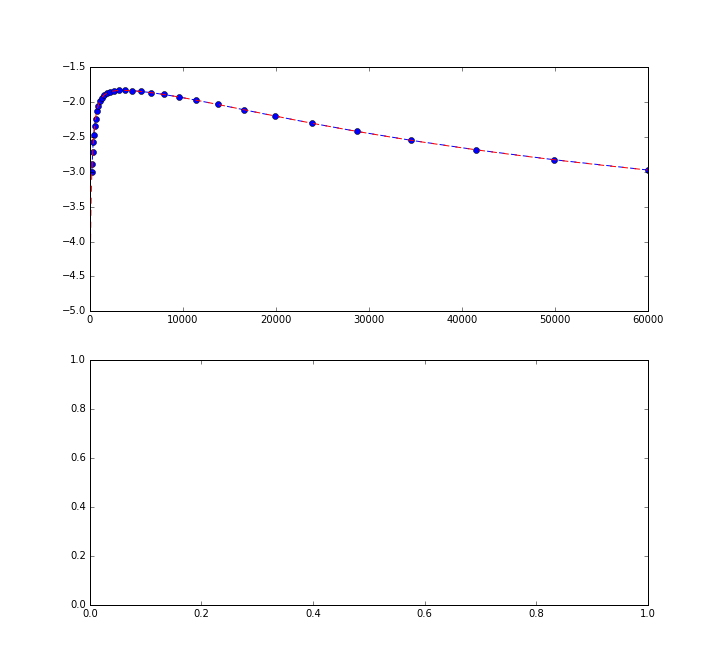

In [163]:
x = interpolate.interp1d(f_selected, g_selected)

g_int = x(f_selected)

fig, ax = plt.subplots(2,1)
ax[0].plot(f_selected, g_int, 'bo--')
ax[0].plot(freqs, g_cont,'r--')